<p>
This project was created by leveraging the code provided by [Matterport, Inc.](https://github.com/matterport/Mask_RCNN). The structure of this project was copied from Matterport's [demo Jupyter Notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb). They also give a great explanation of how instance segmentation works in this [tutorial](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).
</p>

<p>
This YouTube [video](https://www.youtube.com/watch?v=2TikTv6PWDw) by Mark Jay was very helpful in explaining how to install all the necessary packages.   
</p>

In [1]:
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
import mrcnn.model as modellib
import numpy as np
import os
import random
import skimage.io
import sys
import tensorflow as tf
import time

from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from mrcnn import coco
from mrcnn import utils
from mrcnn import visualize

%matplotlib inline

/anaconda3/envs/newest/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Override the default config settings

In [17]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

### Create Instance Segmentation Model and Load Trained Weights
#### mask_rcnn_coco.h5 is not saved on my GitHub due to the large file size restriction. You can download it [here](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5). After downloading it, move the file to the same folder as this Jupyter Notebook.

In [18]:
# Create model object in inference mode.
seg_model = modellib.MaskRCNN(mode='inference', model_dir='', config=config)

# Load weights trained on MS-COCO
seg_model.load_weights('mask_rcnn_coco.h5', by_name=True)

### Create pretrained InceptionV3 model. Used for detecting sunglasses.

In [19]:
sunglasses_model = InceptionV3(weights='imagenet')

### Class Names

In [20]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Haar Cascades is used to find the bounding box coordinates of a face. 

In [45]:
def get_bbox_of_face(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cascade_file_path = 'haarcascade_frontalface_default.xml'
    cascade_clf = cv2.CascadeClassifier(cascade_file_path)

    faces = cascade_clf.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5)

    return faces[0] if len(faces) > 0 else None

In [53]:
def person_has_sunglasses(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, (299, 299))
    img_resized = img_to_array(img_resized)
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = preprocess_input(img_resized)

    preds = sunglasses_model.predict(img_resized)
    preds_decoded = imagenet_utils.decode_predictions(preds)
    
    has_sunglasses = False
    for imagenetID, label, prob in preds_decoded[0][:2]:
        if label == 'sunglass' or label == 'sunglasses':
            has_sunglasses = True
            break
    
    return has_sunglasses

## Run Instance Segmentation

In [60]:
def process_frame(frame, background):
    pass

In [56]:
img_names = ['background.jpg', 'cup.jpg', 'glasses_book.jpg', 'glasses.jpg', 'horse.jpg']
img = cv2.imread('images/{}'.format(img_names[2]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_background = cv2.imread('images/{}'.format(img_names[0]))
img_background = cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB)

total time (seconds) 15.264631032943726


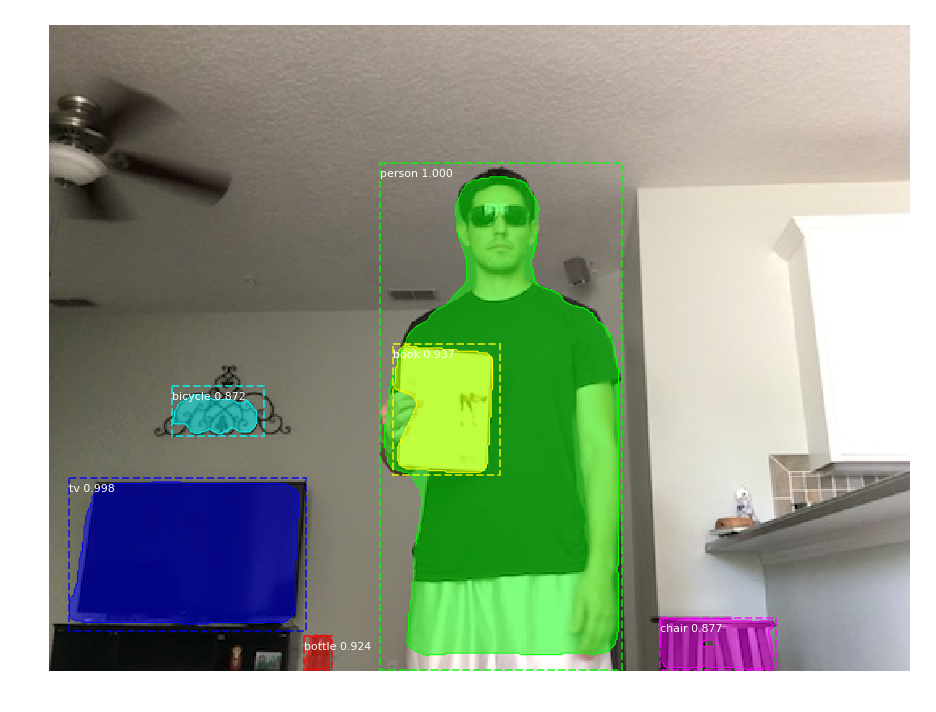

In [57]:
# Run detection
start = time.time()
results = seg_model.detect([img], verbose=0)

end = time.time()
print('total time (seconds)', end - start)

# Visualize results
results = results[0]
visualize.display_instances(img, results['rois'], results['masks'], results['class_ids'], 
                            class_names, results['scores'])

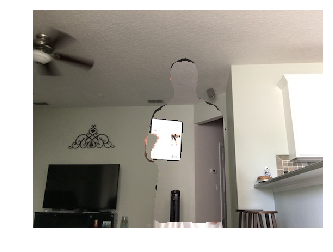

In [59]:
# shape of the masks are (h, w, object_ix)

n_objects_found = len(results['class_ids'])
for ix in range(n_objects_found):
    if results['class_ids'][ix] == class_names.index('person'):
        bbox = get_bbox_of_face(img)
        if bbox is not None:
            x, y, w, h = bbox
            img_face = img[y : y+h, x : x+w]
            if person_has_sunglasses(img_face):
                person_mask = results['masks'][:, :, ix]
                other_masks = np.delete(results['masks'], ix, axis=2)
                other_masks_merged = np.logical_or.reduce(other_masks, axis=2)
                mask = person_mask & np.logical_not(other_masks_merged)

                img_copy = np.copy(img)
                img_copy[mask] = img_background[mask]
                cv2.imwrite('test.png', img_copy)

plt.axis('off')        
plt.imshow(img_copy)